# Testing some concepts in here

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## LSTM-based Autoencoder with Temporal Attention

Basic concept: Input -> LSTM (x times) Encoder -> Attention Layer -> LSTM (x times) Decoder -> Output.

- Encoder catches temporal dependencies across entire input (due to long term memory) and captures patterns
- Attention layer learns about which elements of the encoded input are most important for the current prediction
- Decoder generates future data from the attention-filtered data and its learned (long term memory) weights

Since we want to predict sequence of data and not just the next step, we also need a simple Seq2Seq model which just adds the newly generated data as normal data points to include in the prediction of the next one

In [63]:
# ------------------------------
# Encoder: BiLSTM
# ------------------------------
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
    
    def forward(self, x):
        outputs, (h_n, c_n) = self.lstm(x)
        return outputs, (h_n, c_n)

# ------------------------------
# Temporal Attention (fixed for bidirectional)
# ------------------------------
class TemporalAttention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.W = nn.Linear(encoder_hidden_dim * 2 + decoder_hidden_dim * 2, decoder_hidden_dim * 2)
        self.v = nn.Linear(decoder_hidden_dim * 2, 1, bias=False)
    
    def forward(self, decoder_hidden, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.size()
        decoder_hidden_exp = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.W(torch.cat((decoder_hidden_exp, encoder_outputs), dim=2)))
        attention = F.softmax(self.v(energy), dim=1)
        context = torch.sum(attention * encoder_outputs, dim=1)
        return context

# ------------------------------
# Decoder: BiLSTM with attention
# ------------------------------
class Decoder(nn.Module):
    def __init__(self, input_size=1, encoder_hidden_size=64, hidden_size=64, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.encoder_hidden_size = encoder_hidden_size
        self.attn = TemporalAttention(encoder_hidden_size, hidden_size)
        self.lstm = nn.LSTM(input_size + 2*encoder_hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, y_prev, encoder_outputs, hidden=None):
        batch_size = y_prev.size(0)
        if hidden is None:
            h_0 = torch.zeros(2, batch_size, self.hidden_size, device=y_prev.device)
            c_0 = torch.zeros(2, batch_size, self.hidden_size, device=y_prev.device)
            hidden = (h_0, c_0)
        
        h_cat = torch.cat((hidden[0][-2,:,:], hidden[0][-1,:,:]), dim=1)
        context = self.attn(h_cat, encoder_outputs)
        lstm_input = torch.cat([y_prev, context.unsqueeze(1)], dim=2)
        lstm_out, hidden = self.lstm(lstm_input, hidden)
        pred = self.fc(lstm_out.squeeze(1))
        return pred, hidden

# ------------------------------
# Seq2Seq model wrapper
# ------------------------------
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, pred_len=10):
        encoder_outputs, _ = self.encoder(src)
        y_prev = src[:, -1:, :]  # last value as initial input
        hidden = None
        outputs = []
        for _ in range(pred_len):
            pred, hidden = self.decoder(y_prev, encoder_outputs, hidden)
            outputs.append(pred.unsqueeze(1))
            y_prev = pred.unsqueeze(1)
        return torch.cat(outputs, dim=1)


To test it, we create a dataset based on some mathematical functions with some noise added to it

In [64]:
# ------------------------------
# Synthetic data generation for multiple functions
# ------------------------------
def generate_multi_function_data(seq_len=60, pred_len=20, num_samples=2000):
    funcs = [
        lambda x: np.sin(x),
        lambda x: np.cos(x),
        lambda x: np.sin(2*x),
        lambda x: np.exp(-0.05*x) * np.sin(x),
        lambda x: 0.1 * x,
        lambda x: 0.05 * (x**2),
    ]
    X, Y = [], []
    for _ in range(num_samples):
        f = np.random.choice(funcs)
        x = np.linspace(0, 10, seq_len + pred_len)
        a = np.random.normal(1, 0.2)
        noise = 0.05 * np.random.randn(len(x))
        phase = np.random.rand() * 2*np.pi
        series = f(a*x + phase) + noise
        X.append(series[:seq_len].reshape(-1, 1))
        Y.append(series[seq_len:].reshape(-1, 1))
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

And here a simple training loop and model construction

In [65]:
# ------------------------------
# Training setup
# ------------------------------
seq_len = 40
pred_len = 10
batch_size = 32
num_samples = 1500
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("Using " + str(device))

X, Y = generate_multi_function_data(seq_len, pred_len, num_samples)
dataset = torch.utils.data.TensorDataset(torch.tensor(X), torch.tensor(Y))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

encoder = Encoder(input_size=1, hidden_size=128).to(device)
decoder = Decoder(input_size=1, encoder_hidden_size=128, hidden_size=128, output_size=1).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ------------------------------
# Training loop
# ------------------------------
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        pred = model(batch_x, pred_len=pred_len)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataset):.6f}")

Using mps
Epoch 1/100, Loss: 3.470167
Epoch 2/100, Loss: 0.696237
Epoch 3/100, Loss: 0.495728
Epoch 4/100, Loss: 0.437383
Epoch 5/100, Loss: 0.424652
Epoch 6/100, Loss: 0.357256
Epoch 7/100, Loss: 0.328918
Epoch 8/100, Loss: 0.268084
Epoch 9/100, Loss: 0.226518
Epoch 10/100, Loss: 0.161203
Epoch 11/100, Loss: 0.169496
Epoch 12/100, Loss: 0.156341
Epoch 13/100, Loss: 0.148565
Epoch 14/100, Loss: 0.112622
Epoch 15/100, Loss: 0.124567
Epoch 16/100, Loss: 0.103888
Epoch 17/100, Loss: 0.113220
Epoch 18/100, Loss: 0.083195
Epoch 19/100, Loss: 0.101058
Epoch 20/100, Loss: 0.062288
Epoch 21/100, Loss: 0.053767
Epoch 22/100, Loss: 0.047151
Epoch 23/100, Loss: 0.038703
Epoch 24/100, Loss: 0.047092
Epoch 25/100, Loss: 0.040955
Epoch 26/100, Loss: 0.029325
Epoch 27/100, Loss: 0.023915
Epoch 28/100, Loss: 0.029383
Epoch 29/100, Loss: 0.030389
Epoch 30/100, Loss: 0.017964
Epoch 31/100, Loss: 0.021833
Epoch 32/100, Loss: 0.022880
Epoch 33/100, Loss: 0.021876
Epoch 34/100, Loss: 0.046442
Epoch 35/100,

Some visualization of the results using functions that were (approximately) learned before and also some new data


--- Known Functions ---


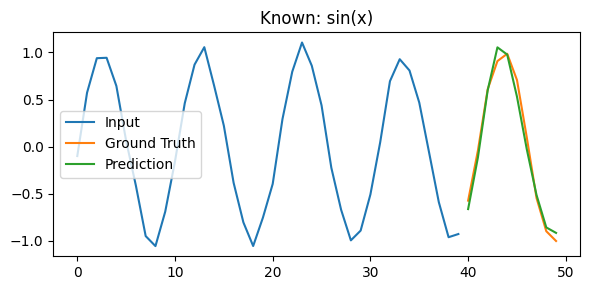

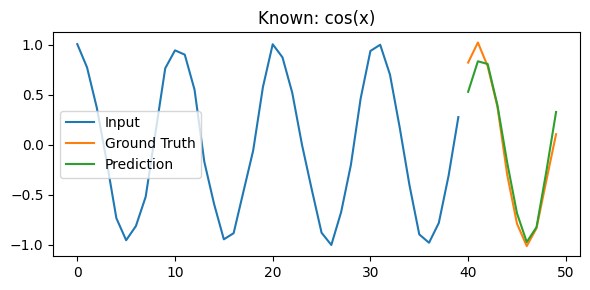

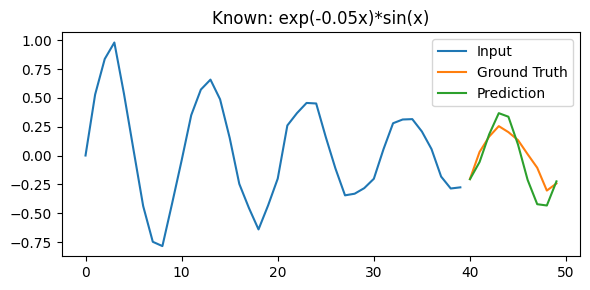

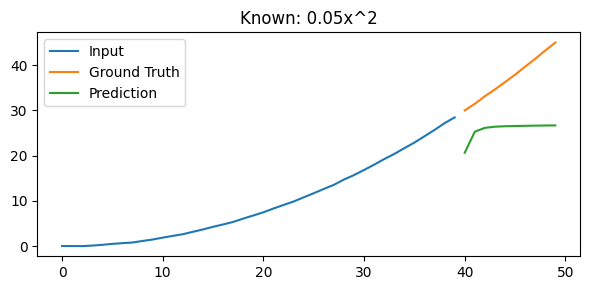


--- Unseen Functions ---


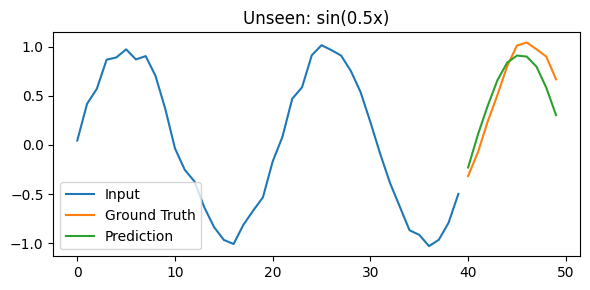

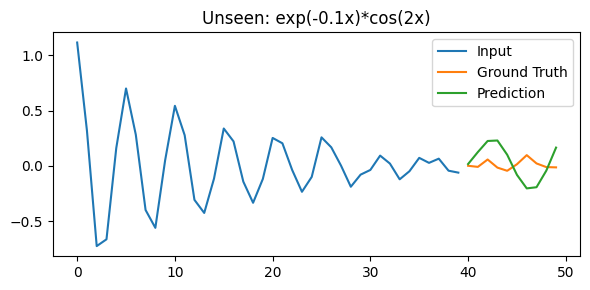

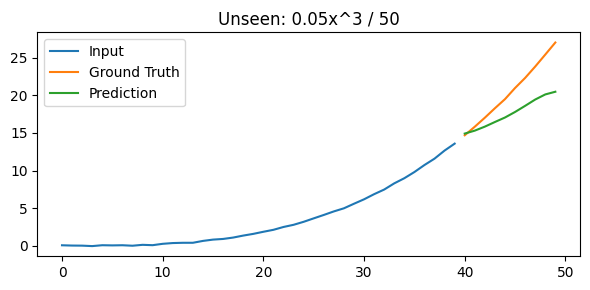

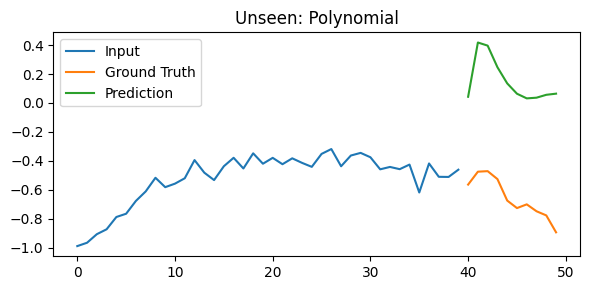

In [66]:
# ------------------------------
# Visualization helpers
# ------------------------------
def visualize_prediction(model, f, seq_len, pred_len, title, noise_level=0.05):
    x = np.linspace(0, 30, seq_len + pred_len)
    noise = noise_level * np.random.randn(len(x))
    series = f(x) + noise
    X_input = torch.tensor(series[:seq_len].reshape(1, seq_len, 1), dtype=torch.float32).to(device)
    Y_true = series[seq_len:]
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_input, pred_len=pred_len).cpu().numpy()[0,:,0]
    
    plt.figure(figsize=(6,3))
    plt.plot(range(seq_len), series[:seq_len], label='Input')
    plt.plot(range(seq_len, seq_len+pred_len), Y_true, label='Ground Truth')
    plt.plot(range(seq_len, seq_len+pred_len), Y_pred, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------
# Test on both known and unseen functions
# ------------------------------
known_funcs = [
    ("sin(x)", lambda x: np.sin(x)),
    ("cos(x)", lambda x: np.cos(x)),
    ("exp(-0.05x)*sin(x)", lambda x: np.exp(-0.05*x)*np.sin(x)),
    ("0.05x^2", lambda x: 0.05*x**2),
]

unseen_funcs = [
    ("sin(0.5x)", lambda x: np.sin(0.5*x)),
    ("exp(-0.1x)*cos(2x)", lambda x: np.exp(-0.1*x)*np.cos(2*x)),
    ("0.05x^3 / 50", lambda x: 0.05*(x**3)/50),
    ("Polynomial", lambda x: -1+0.1*x-0.005*x**2+0.00005*x**3+0.000002*x**4-0.000000025*x**5-0.000000001*x**6)
]

print("\n--- Known Functions ---")
for name, f in known_funcs:
    visualize_prediction(model, f, seq_len, pred_len, f"Known: {name}")

print("\n--- Unseen Functions ---")
for name, f in unseen_funcs:
    visualize_prediction(model, f, seq_len, pred_len, f"Unseen: {name}")


# Using a U-Net-like structure but with LSTM blocks

In [81]:
# ------------------------------
# Encoder: BiLSTM Funnel
# ------------------------------
class UEncoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size//4, batch_first=True, bidirectional=True, num_layers=3)
        self.lstm2 = nn.LSTM(hidden_size//2, hidden_size//2, batch_first=True, bidirectional=True, num_layers=3)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True, num_layers=3)
    
    def forward(self, x):
        out1, _ = self.lstm1(x)  # out1: (B, seq_len, hidden_size/4 * 2)
        out2, _ = self.lstm2(out1)  # out2: (B, seq_len, hidden_size/2 * 2)
        out3, _ = self.lstm3(out2)  # out3: (B, seq_len, hidden_size * 2)
        return out3, (out1, out2, out3)

# ------------------------------
# Temporal Attention
# ------------------------------
class UTemporalAttention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.W = nn.Linear(encoder_hidden_dim * 2 + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Linear(decoder_hidden_dim, 1, bias=False)
    
    def forward(self, decoder_hidden, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.size()
        decoder_hidden_exp = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.W(torch.cat((decoder_hidden_exp, encoder_outputs), dim=2)))
        attention = F.softmax(self.v(energy), dim=1)
        context = torch.sum(attention * encoder_outputs, dim=1)
        return context
    
# ------------------------------
# Decoder with skip connections (parallel)
# ------------------------------
class UDecoderParallel(nn.Module):
    def __init__(self, input_size=1, encoder_hidden_size=128, hidden_size=128, output_size=1, pred_len=10):
        super().__init__()
        self.hidden_size = hidden_size
        self.encoder_hidden_size = encoder_hidden_size
        self.pred_len = pred_len

        # Projected attention
        self.attn = UTemporalAttention(encoder_hidden_size, hidden_size)

        # LSTM blocks (unidirectional)
        # Input shapes consider full sequence length = pred_len
        self.lstm3 = nn.LSTM(input_size + 2*encoder_hidden_size + 2*hidden_size, hidden_size, batch_first=True, num_layers=3)
        self.lstm2 = nn.LSTM(hidden_size + encoder_hidden_size, hidden_size//2, batch_first=True, num_layers=3)
        self.lstm1 = nn.LSTM(hidden_size//2 + encoder_hidden_size//2, hidden_size//4, batch_first=True, num_layers=3)

        self.fc = nn.Linear(hidden_size//4, output_size)

    def forward(self, y_init, encoder_outputs, encoder_intermediates):
        """
        y_init: (B, 1, input_size), initial input for all steps
        encoder_outputs: (B, seq_len_enc, 2*hidden_size)
        encoder_intermediates: tuple of (out1, out2, out3)
        """
        batch_size = y_init.size(0)
        seq_len_enc = encoder_outputs.size(1)

        # Repeat initial input for pred_len
        y_seq = y_init.repeat(1, self.pred_len, 1)  # (B, pred_len, input_size)

        out1_enc, out2_enc, out3_enc = encoder_intermediates

        # Compute attention context for each decoder time step
        # Repeat decoder hidden dummy along pred_len
        dummy_decoder_hidden = torch.zeros(batch_size, self.hidden_size, device=y_init.device)
        context_seq = self.attn(dummy_decoder_hidden, encoder_outputs)  # (B, 2*encoder_hidden)
        context_seq = context_seq.unsqueeze(1).repeat(1, self.pred_len, 1)  # (B, pred_len, 2*encoder_hidden)

        # LSTM3 input: initial y + context + skip out3
        lstm3_input = torch.cat([y_seq, context_seq, out3_enc[:, -self.pred_len:, :]], dim=2)
        out3, _ = self.lstm3(lstm3_input)

        # LSTM2 input: out3 + skip out2
        lstm2_input = torch.cat([out3, out2_enc[:, -self.pred_len:, :]], dim=2)
        out2, _ = self.lstm2(lstm2_input)

        # LSTM1 input: out2 + skip out1
        lstm1_input = torch.cat([out2, out1_enc[:, -self.pred_len:, :]], dim=2)
        out1, _ = self.lstm1(lstm1_input)

        pred = self.fc(out1)  # shape (B, pred_len, output_size)
        return pred
    
class USeq2SeqParallel(nn.Module):
    def __init__(self, encoder, decoder, device, pred_len=10):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pred_len = pred_len

    def forward(self, src):
        # Encode
        encoder_outputs, encoder_intermediates = self.encoder(src)

        # Initial input (last known value)
        y_init = src[:, -1:, :]  # shape (B, 1, input_size)

        # Decode full sequence in parallel
        pred = self.decoder(y_init, encoder_outputs, encoder_intermediates)
        return pred  # shape (B, pred_len, output_size)


In [82]:
# ------------------------------
# Training setup
# ------------------------------
seq_len = 40
pred_len = 10
batch_size = 32
num_samples = 3600

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("Using " + str(device))

# Generate data
X, Y = generate_multi_function_data(seq_len, pred_len, num_samples)
dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), 
                                        torch.tensor(Y, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize encoder, decoder, and parallel Seq2Seq model
encoder = UEncoder(input_size=1, hidden_size=128).to(device)
decoder = UDecoderParallel(input_size=1, encoder_hidden_size=128, hidden_size=128, output_size=1, pred_len=pred_len).to(device)
model = USeq2SeqParallel(encoder, decoder, device, pred_len=pred_len).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ------------------------------
# Training loop
# ------------------------------
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        # Forward pass (parallel decoder)
        pred = model(batch_x)  # pred shape: (B, pred_len, 1)

        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataset):.6f}")

Using mps
Epoch 1/100, Loss: 6.385547
Epoch 2/100, Loss: 1.800208
Epoch 3/100, Loss: 0.968111
Epoch 4/100, Loss: 0.593761
Epoch 5/100, Loss: 0.419058
Epoch 6/100, Loss: 0.297005
Epoch 7/100, Loss: 0.246888
Epoch 8/100, Loss: 0.176478
Epoch 9/100, Loss: 0.131972
Epoch 10/100, Loss: 0.118098
Epoch 11/100, Loss: 0.085958
Epoch 12/100, Loss: 0.070202
Epoch 13/100, Loss: 0.059840
Epoch 14/100, Loss: 0.057146
Epoch 15/100, Loss: 0.048992
Epoch 16/100, Loss: 0.043348
Epoch 17/100, Loss: 0.036829
Epoch 18/100, Loss: 0.031906
Epoch 19/100, Loss: 0.025528
Epoch 20/100, Loss: 0.022486
Epoch 21/100, Loss: 0.021345
Epoch 22/100, Loss: 0.024814
Epoch 23/100, Loss: 0.018291
Epoch 24/100, Loss: 0.017478
Epoch 25/100, Loss: 0.017186
Epoch 26/100, Loss: 0.061587
Epoch 27/100, Loss: 0.021966
Epoch 28/100, Loss: 0.014109
Epoch 29/100, Loss: 0.021685
Epoch 30/100, Loss: 0.012454
Epoch 31/100, Loss: 0.012633
Epoch 32/100, Loss: 0.011933
Epoch 33/100, Loss: 0.020939
Epoch 34/100, Loss: 0.012452
Epoch 35/100,


--- Known Functions ---


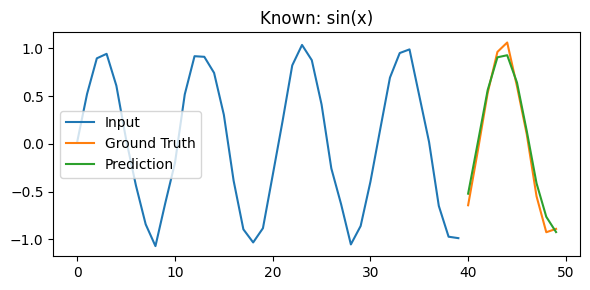

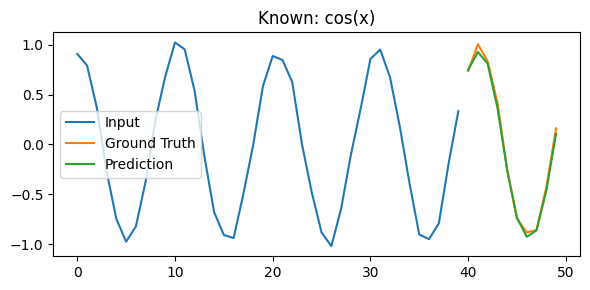

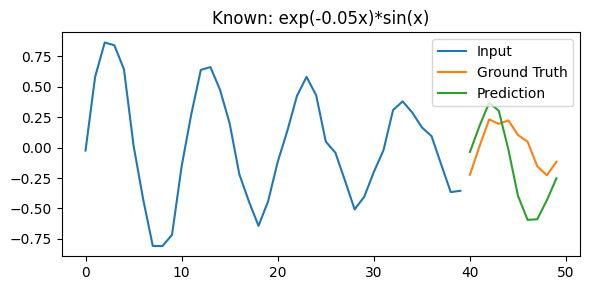

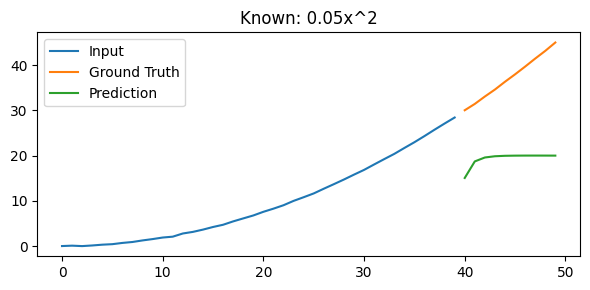


--- Unseen Functions ---


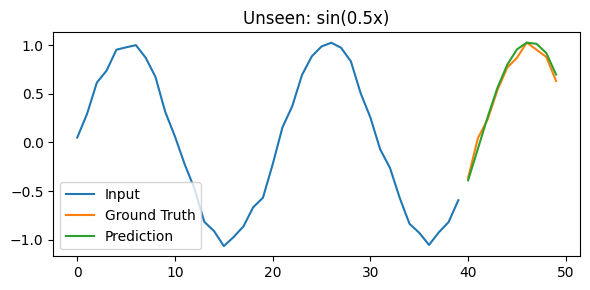

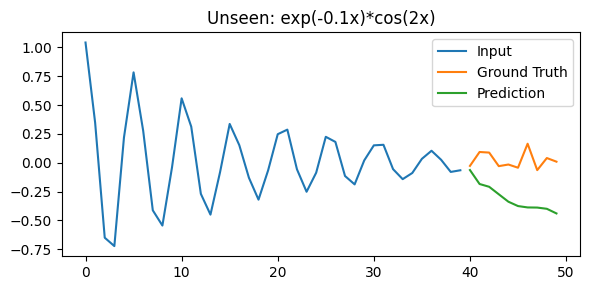

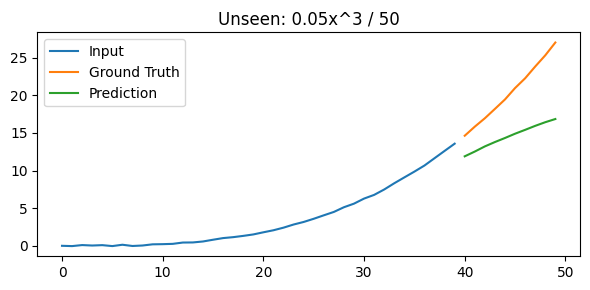

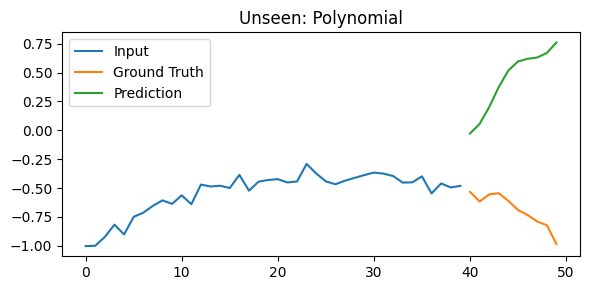

In [83]:
# ------------------------------
# Visualization helpers (updated for parallel decoder)
# ------------------------------
def visualize_prediction(model, f, seq_len, pred_len, title, noise_level=0.05):
    x = np.linspace(0, 30, seq_len + pred_len)
    noise = noise_level * np.random.randn(len(x))
    series = f(x) + noise

    # Prepare input tensor
    X_input = torch.tensor(series[:seq_len].reshape(1, seq_len, 1), dtype=torch.float32).to(device)
    Y_true = series[seq_len:]

    # Model prediction
    model.eval()
    with torch.no_grad():
        # Parallel decoder predicts all steps at once
        Y_pred = model(X_input).cpu().numpy()[0, :, 0]

    # Plot
    plt.figure(figsize=(6, 3))
    plt.plot(range(seq_len), series[:seq_len], label='Input')
    plt.plot(range(seq_len, seq_len + pred_len), Y_true, label='Ground Truth')
    plt.plot(range(seq_len, seq_len + pred_len), Y_pred, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------
# Test on both known and unseen functions
# ------------------------------
known_funcs = [
    ("sin(x)", lambda x: np.sin(x)),
    ("cos(x)", lambda x: np.cos(x)),
    ("exp(-0.05x)*sin(x)", lambda x: np.exp(-0.05*x)*np.sin(x)),
    ("0.05x^2", lambda x: 0.05*x**2),
]

unseen_funcs = [
    ("sin(0.5x)", lambda x: np.sin(0.5*x)),
    ("exp(-0.1x)*cos(2x)", lambda x: np.exp(-0.1*x)*np.cos(2*x)),
    ("0.05x^3 / 50", lambda x: 0.05*(x**3)/50),
    ("Polynomial", lambda x: -1+0.1*x-0.005*x**2+0.00005*x**3+0.000002*x**4-0.000000025*x**5-0.000000001*x**6)
]

print("\n--- Known Functions ---")
for name, f in known_funcs:
    visualize_prediction(model, f, seq_len, pred_len, f"Known: {name}")

print("\n--- Unseen Functions ---")
for name, f in unseen_funcs:
    visualize_prediction(model, f, seq_len, pred_len, f"Unseen: {name}")